# BIG QUERY PROJECT

Lyft Bay Wheels (https://www.lyft.com/bikes/bay-wheels), formerly known as Ford GoBike, the company running Bay Area Bikeshare. I will be analysing the public data with the goal to suggest deals and offers to increase ridership.
  
I will answer these main questions: 

  * What the popular "commuter trips"? 
  
  * What are your recommendations for offers (justified based findings)?


To make my recommendations, I will need to perform data exploration, cleaning or filtering dirty data, etc. to provide supporting data for my recommendations. 

I be answering these business-driven questions using public datasets housed in Google Cloud Platform (GCP) and quering the data with SQL.

In [44]:
import os
os.getcwd()

'/Users/dera/Desktop/github/lyft-bikes'

In [45]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='/Users/dera/Desktop/github/lyft-bikes/w205-300800-f62fea1f1496.json'

In [46]:
# To import big query (bq) and bq client.

from google.cloud import bigquery

bigquery_client = bigquery.Client()

import seaborn as sns

I will be using the **san_francisco_bikeshare** dataset. 

This dataset has tables bikeshare_regions, bikeshare_station_info, bikeshare_station_status, bikeshare trips.

### Initial questions to understand the dataset

- What's the number of trips in the data set?

- How many bikes are there?

- What is the length of a trip?

- What is the earliest start date and latest end date for a trip in the dataset?

In [47]:
# Query the number of unique trips in the bikeshare_trips table

trips_size_query = """

SELECT 
  count(trip_id) as trips_size
  
FROM 
  `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` 
  
"""

trips_size_job = bigquery_client.query(trips_size_query)
trips_size_df = trips_size_job.to_dataframe()
display(trips_size_df)

,trips_size
0,1947419


In [48]:
# Query the number of bikes in the bikeshare_trips table

bikes_no_query = """

SELECT 
  count(DISTINCT bike_number) as no_of_bikes
  
FROM 
  `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` 
  
"""

bikes_no_job = bigquery_client.query(bikes_no_query)
bikes_no_df = bikes_no_job.to_dataframe()
display(bikes_no_df)

,no_of_bikes
0,3952


In [49]:
# Query the length of a trip

trip_length_query = """

SELECT 
  AVG(duration_sec) as average_duration_sec
  
FROM 
  `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` 
  
"""

trip_length_job = bigquery_client.query(trip_length_query)
trip_length_df = trip_length_job.to_dataframe()
display(trip_length_df)

,average_duration_sec
0,1007.971298


In [50]:
# Query the earliest start date  for a trip in the dataset
earliest_start_date_query = """

SELECT 
  EXTRACT(DATE FROM start_date) as earliest_start_date_
  
FROM 
  `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` 
  
ORDER BY
  start_date ASC 
  
LIMIT 1
  
"""

earliest_start_date_job = bigquery_client.query(earliest_start_date_query)
earliest_start_date_df = earliest_start_date_job.to_dataframe()
display(earliest_start_date_df)

# Query the latest end date for a trip in the dataset

latest_start_date_query = """

SELECT 
  EXTRACT(DATE FROM start_date) as latest_start_date_
  
FROM 
  `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` 
  
ORDER BY
  start_date DESC 
  
LIMIT 1
  
"""

latest_start_date_job = bigquery_client.query(latest_start_date_query)
latest_start_date_df = latest_start_date_job.to_dataframe()
display(latest_start_date_df)

,earliest_start_date_
0,2013-08-29


,latest_start_date_
0,2018-04-30


### Deep dive into the trip routes

- What's the most popular stations to start and end trips?

- What are the most popular routes?

In [51]:
# Query the most popular start stations

start_stations_query = """

SELECT 
  A.start_station_name, C.name as region_name, count(*) as freq 
  
FROM 
  `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` AS A
  
LEFT JOIN
  `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` AS B
  
ON
  A.start_station_id = B.station_id
  
LEFT JOIN 
  `bigquery-public-data.san_francisco_bikeshare.bikeshare_regions` AS C
  
ON
  B.region_id = C.region_id
  
GROUP BY 
  A.start_station_name, C.name
  
ORDER BY
  freq DESC 
  
LIMIT 25

"""

start_stations_job = bigquery_client.query(start_stations_query)
start_stations_df = start_stations_job.to_dataframe()
display(start_stations_df[:5])

,start_station_name,region_name,freq
0,San Francisco Caltrain (Townsend at 4th),San Francisco,72683
1,San Francisco Caltrain 2 (330 Townsend),None,56100
2,Harry Bridges Plaza (Ferry Building),San Francisco,49062
3,Embarcadero at Sansome,San Francisco,41137
4,2nd at Townsend,San Francisco,39936


In [52]:
# Query the most popular end stations

end_stations_query = """

SELECT 
  A.end_station_name, C.name as region_name, count(*) as freq 
  
FROM 
  `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` AS A
  
LEFT JOIN
  `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` AS B
  
ON
  A.end_station_id = B.station_id
  
LEFT JOIN 
  `bigquery-public-data.san_francisco_bikeshare.bikeshare_regions` AS C
  
ON
  B.region_id = C.region_id
  
GROUP BY 
  A.end_station_name, C.name
  
ORDER BY
  freq DESC 
  
LIMIT 25

"""

end_stations_job = bigquery_client.query(end_stations_query)
end_stations_df = end_stations_job.to_dataframe()
display(end_stations_df[:5])

,end_station_name,region_name,freq
0,San Francisco Caltrain (Townsend at 4th),San Francisco,92014
1,San Francisco Caltrain 2 (330 Townsend),None,58713
2,Harry Bridges Plaza (Ferry Building),San Francisco,50185
3,Embarcadero at Sansome,San Francisco,46197
4,2nd at Townsend,San Francisco,44145


In [53]:
# Query the most popular trip routes

trip_route_query = """
SELECT 
  start_station_name, end_station_name, count(*) as trip_freq 
  
FROM 
  `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` 
  
GROUP BY 
  start_station_name, end_station_name 
  
ORDER BY 
  trip_freq DESC 

LIMIT 5

"""

trip_route_job = bigquery_client.query(trip_route_query)
trip_route_df = trip_route_job.to_dataframe()
display(trip_route_df[:5])

,start_station_name,end_station_name,trip_freq
0,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,9150
1,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,8508
2,2nd at Townsend,Harry Bridges Plaza (Ferry Building),7620
3,Harry Bridges Plaza (Ferry Building),2nd at Townsend,6888
4,Embarcadero at Sansome,Steuart at Market,6874


### Deep dive into time trips are taken

- What times are trips most usually taken?

In [54]:
# Query the most trip start times

start_time_query = """

SELECT 
  EXTRACT(HOUR FROM start_date) AS trip_start_hour, count(*) as freq 
  
FROM 
  `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` 
  
GROUP BY 
  trip_start_hour
  
ORDER BY 
  freq DESC 
  
"""

start_time_job = bigquery_client.query(start_time_query)
start_time_df = start_time_job.to_dataframe()

Text(0.5, 1.0, 'Start Time Popularity')

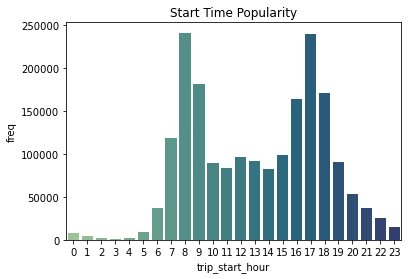

In [55]:
# Plot histogram
sns.barplot(x="trip_start_hour", y="freq", data=start_time_df, palette="crest").set_title('Start Time Popularity')

Looking at the bar chart for most popular trip start times, 8am and 5pm are the most popular hours for trips. The frequency plot has a bimodal distribution around these two times. 

It does appear the "commuting" hours are the most popular hours trips are taken. Morning commute 7am-10am and Evening commute 4pm-7pm. 

Looking at the most popular start/end trip stations as well as the most popular trip routes, it shows that most trips start and end at train stations or popular communting hubs. This shows us that most of the bike users utilize the product as "First and Last Mile Travel". 

#### **Offer Suggestion:**
To better capture and serve these users, I would suggest Lyft Bikes offer a subscription service with discounted rates during these "commuting hours". Such an offer will motivate the use of the bikes in daily commuting routes to and from the train station/hubs.